# Model Selection

## Importing libraries and reading files 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from matplotlib.pylab import rcParams

from imblearn.combine import SMOTETomek

In [2]:
file_path = './Data/trainweather.csv'

In [3]:
combined = pd.read_csv(file_path)

In [4]:
combined.head()

,Unnamed: 0,station,date,tavg,preciptotal,sealevel,resultspeed,resultdir,rel_hum,trap,...,latitude,longitude,year_2009,year_2011,year_2013,mnth_sin,mnth_cos,year_2010,year_2012,year_2014
0,0,1,2007-05-29,74.0,0.0,30.11,5.8,18,57.893159,T002,...,41.954690,-87.800991,0,0,0,0.866025,-0.5,0,0,0
1,1,1,2007-05-29,74.0,0.0,30.11,5.8,18,57.893159,T002,...,41.954690,-87.800991,0,0,0,0.866025,-0.5,0,0,0
2,2,1,2007-05-29,74.0,0.0,30.11,5.8,18,57.893159,T007,...,41.994991,-87.769279,0,0,0,0.866025,-0.5,0,0,0
3,3,1,2007-05-29,74.0,0.0,30.11,5.8,18,57.893159,T015,...,41.974089,-87.824812,0,0,0,0.866025,-0.5,0,0,0
4,4,1,2007-05-29,74.0,0.0,30.11,5.8,18,57.893159,T015,...,41.974089,-87.824812,0,0,0,0.866025,-0.5,0,0,0


In [5]:
combined.columns

Index(['Unnamed: 0', 'station', 'date', 'tavg', 'preciptotal', 'sealevel',
       'resultspeed', 'resultdir', 'rel_hum', 'trap', 'nummosquitos',
       'wnvpresent', 'tot_mos_species', 'species_PIPIENS',
       'species_PIPIENS/RESTUANS', 'species_RESTUANS', 'latitude', 'longitude',
       'year_2009', 'year_2011', 'year_2013', 'mnth_sin', 'mnth_cos',
       'year_2010', 'year_2012', 'year_2014'],
      dtype='object')

## Minor cleaning of data & prepping datasets

In [6]:
X = combined.drop(columns=['station','wnvpresent','trap','date','Unnamed: 0','nummosquitos','tot_mos_species'])
y = combined['wnvpresent']

In [7]:
X.dtypes

tavg                        float64
preciptotal                 float64
sealevel                    float64
resultspeed                 float64
resultdir                     int64
rel_hum                     float64
species_PIPIENS               int64
species_PIPIENS/RESTUANS      int64
species_RESTUANS              int64
latitude                    float64
longitude                   float64
year_2009                     int64
year_2011                     int64
year_2013                     int64
mnth_sin                    float64
mnth_cos                    float64
year_2010                     int64
year_2012                     int64
year_2014                     int64
dtype: object

In [8]:
y.value_counts()

0    8077
1     457
Name: wnvpresent, dtype: int64

Existance of inbalance class

In [9]:
# data's classes are imbalanced, a combination of over-sampling and undersampling will be used 
smt = SMOTETomek(sampling_strategy='auto',
                random_state=42)
X_smt, y_smt = smt.fit_sample(X, y)

In [10]:
X_smt.shape

(15770, 19)

In [11]:
X_smt.head()

,tavg,preciptotal,sealevel,resultspeed,resultdir,rel_hum,species_PIPIENS,species_PIPIENS/RESTUANS,species_RESTUANS,latitude,longitude,year_2009,year_2011,year_2013,mnth_sin,mnth_cos,year_2010,year_2012,year_2014
0,74.0,0.0,30.11,5.8,18,57.893159,0,1,0,41.954690,-87.800991,0,0,0,0.866025,-0.5,0,0,0
1,74.0,0.0,30.11,5.8,18,57.893159,0,0,1,41.954690,-87.800991,0,0,0,0.866025,-0.5,0,0,0
2,74.0,0.0,30.11,5.8,18,57.893159,0,0,1,41.994991,-87.769279,0,0,0,0.866025,-0.5,0,0,0
3,74.0,0.0,30.11,5.8,18,57.893159,0,1,0,41.974089,-87.824812,0,0,0,0.866025,-0.5,0,0,0
4,74.0,0.0,30.11,5.8,18,57.893159,0,0,1,41.974089,-87.824812,0,0,0,0.866025,-0.5,0,0,0


In [12]:
y_smt

0        0
1        0
2        0
3        0
4        0
        ..
15765    1
15766    1
15767    1
15768    1
15769    1
Name: wnvpresent, Length: 15770, dtype: int64

## Baseline Accuracy

In [13]:
y_smt.value_counts(normalize=True)

1    0.5
0    0.5
Name: wnvpresent, dtype: float64

In [14]:
#train test split
X_train,x_val,y_train, y_val = train_test_split(X_smt,y_smt,random_state=42,stratify=y_smt) 

## Model 1: Decision Tree: Hyperparameter Tuning

In [15]:
# Instantiate model
dt = DecisionTreeClassifier() 

In [16]:
# Finding best parameter for model
grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                   param_grid = {'max_depth':[3,5,7,10],
                                'min_samples_split' :[5,10,15,20],
                                'min_samples_leaf':[2,3,4,5,6,7]},
                   cv=5,
                   verbose=1)

In [17]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   10.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 10],
                         

In [18]:
# What is our best decision tree?
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [19]:
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [20]:
grid.best_score_

0.862263782728899

In [21]:
# Instantiate model with best parameters.
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)

# Fit model.
dt.fit(X_train, y_train)

# Evaluate model.
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(x_val, y_val)}')


Score on training set: 0.8865308193117443
Score on testing set: 0.864316510271367


In [22]:
pred_dt = dt.predict(x_val)
print(f'ROC AUC Score on testing set: {roc_auc_score(pred_dt, y_val)}')

ROC AUC Score on testing set: 0.8690311640510295


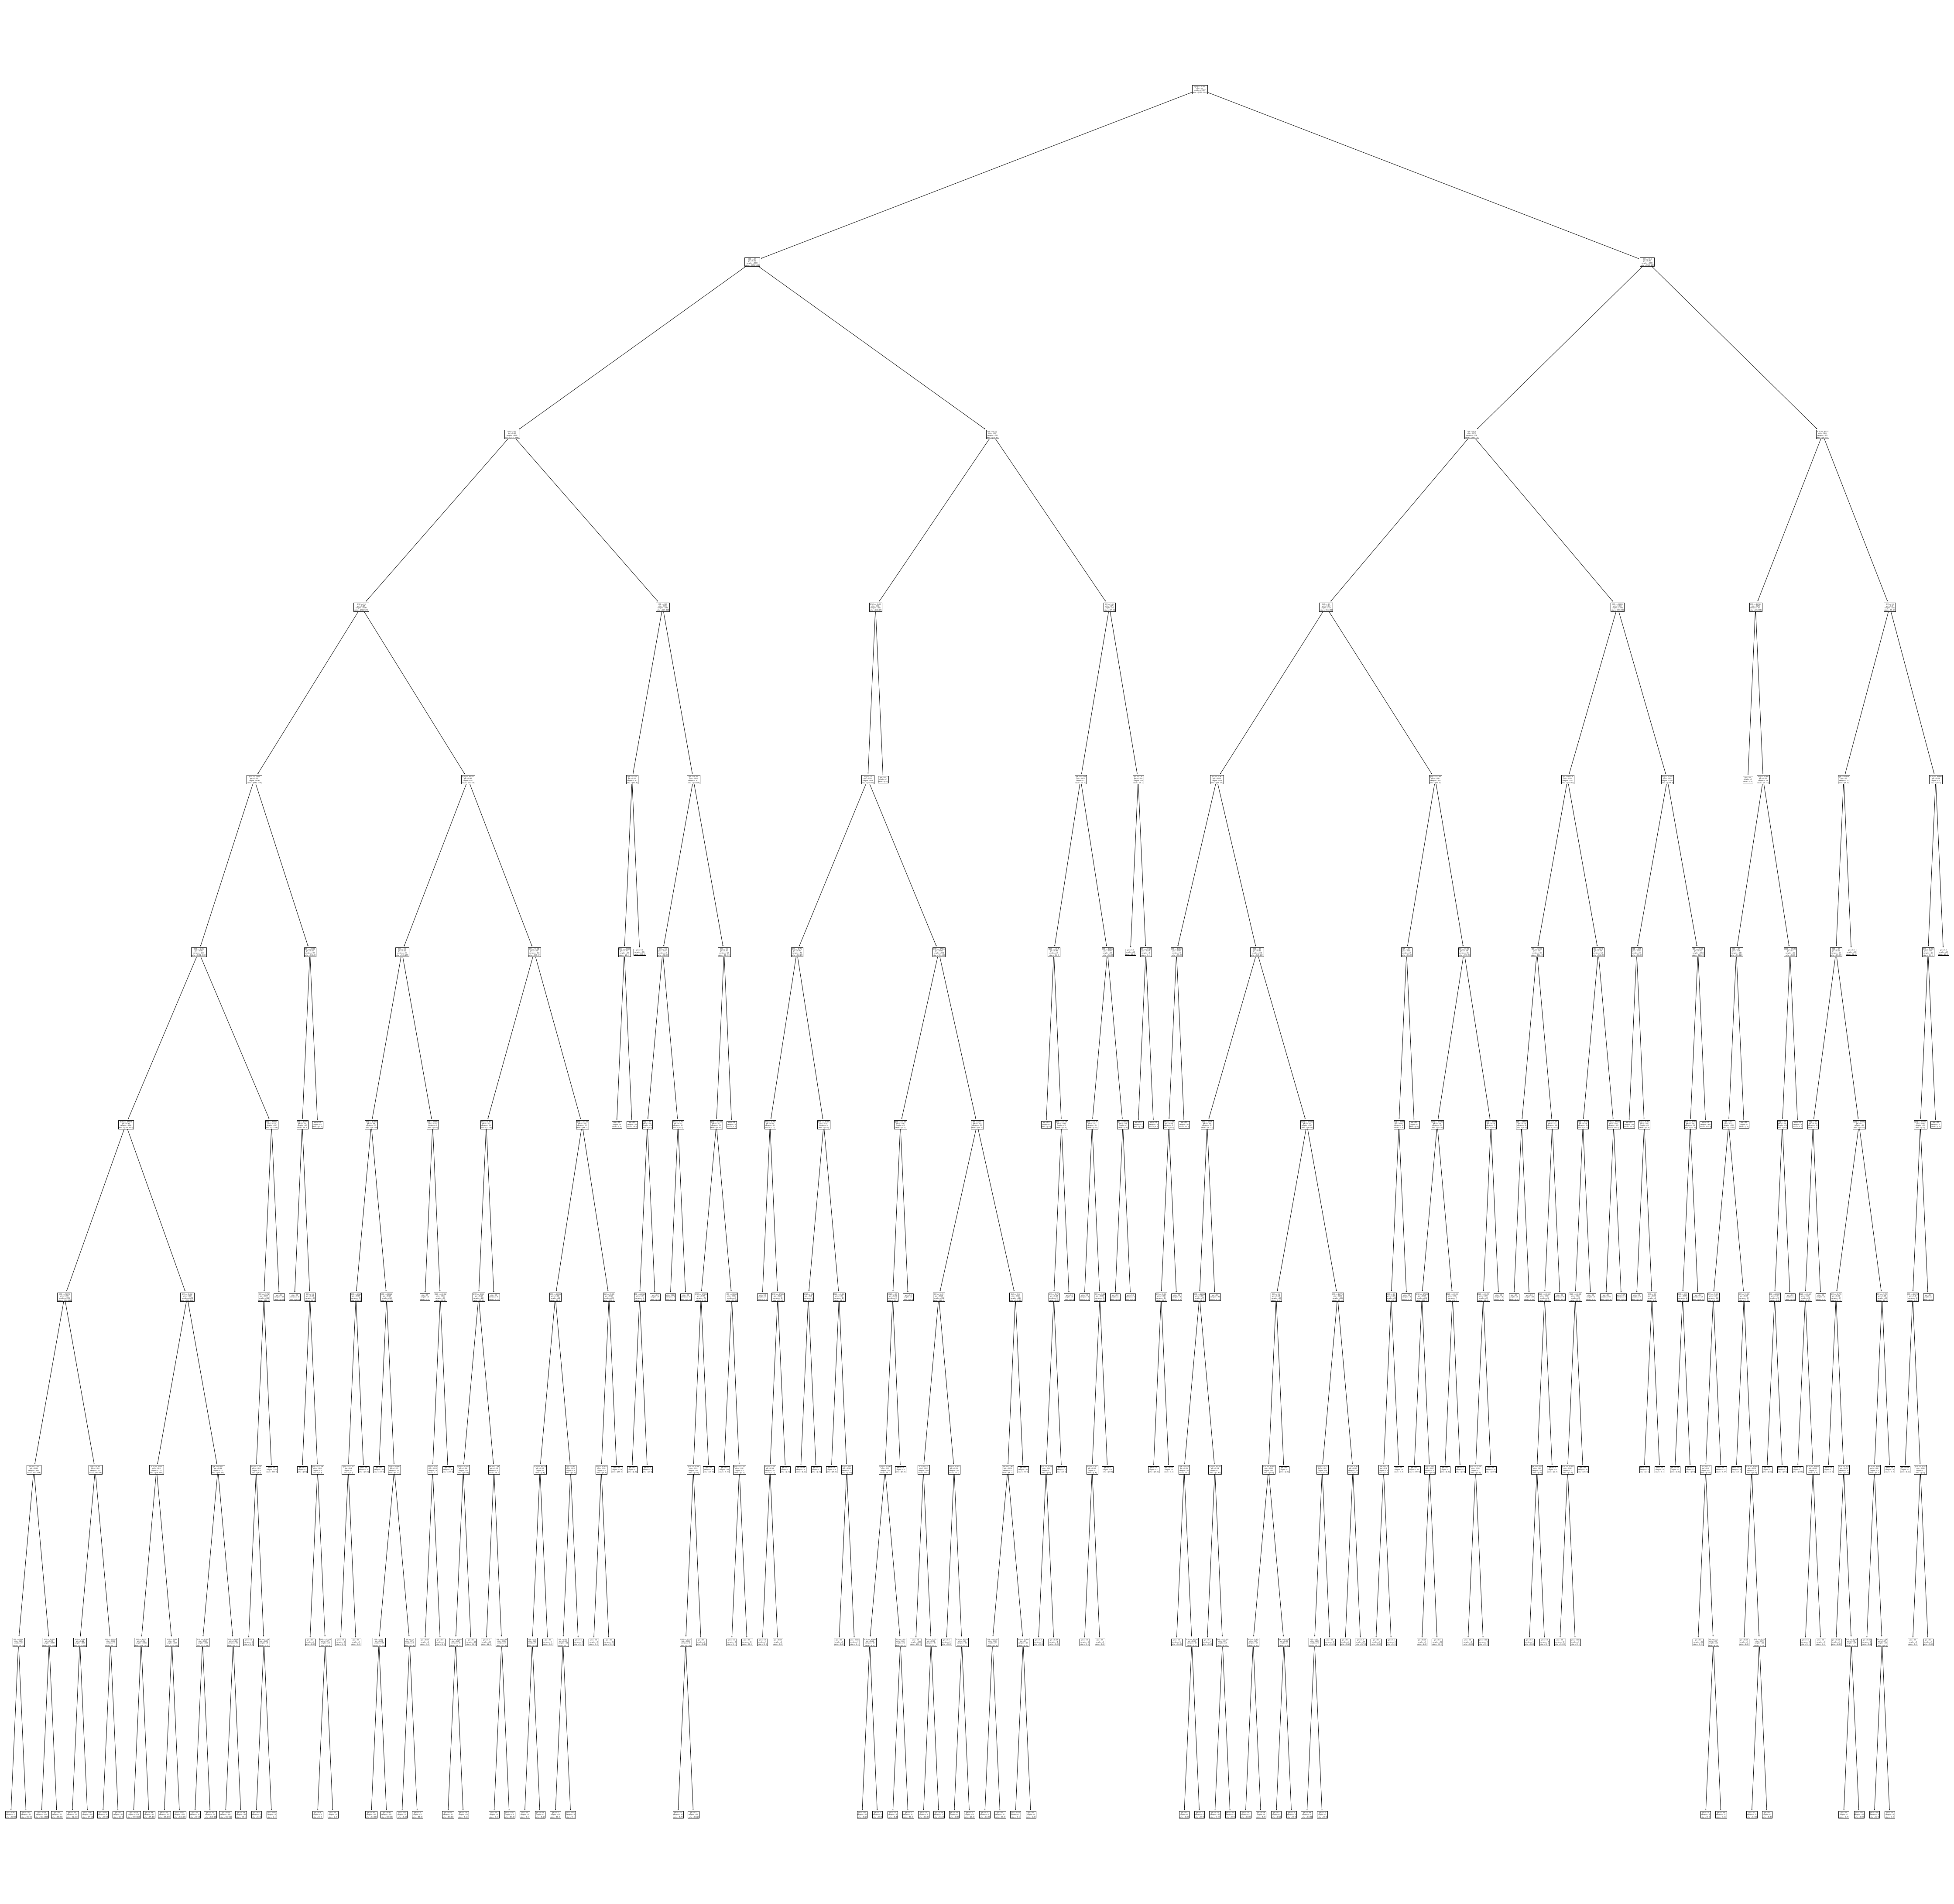

In [23]:
rcParams['figure.figsize'] = 80,80
tree.plot_tree(dt);

## Model 2: Random Forest Classifier - Grid Search

In [24]:
# Instantiate model
rf = RandomForestClassifier()

In [25]:
# Finding best parameter for model
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9333721019588641


{'max_depth': None, 'n_estimators': 200}

In [26]:
gs.score(x_val,y_val)

0.9467410601065179

In [27]:
# Instantiate model with best parameters.
final_model = RandomForestClassifier(n_estimators=200, max_depth=None)
# Fit model.
final_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
# Evaluate model.
final_model.score(x_val,y_val)

0.9467410601065179

In [29]:
pred_rf = final_model.predict(x_val)
print(f'ROC AUC Score on testing set: {roc_auc_score(pred_rf, y_val)}')

ROC AUC Score on testing set: 0.9473340289048613


## Model 3: Ada Boost - Grid Search

In [30]:
# Instantiate model
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())   


# Finding best parameter for model
ada_params ={
    'n_estimators':[50,100],
    'learning_rate' : [0.9,1],
    'base_estimator__max_depth': [1,2,3]
}

gs=GridSearchCV(ada, param_grid=ada_params,cv=3,verbose=1)
gs.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   21.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [31]:
gs.best_params_

{'base_estimator__max_depth': 3, 'learning_rate': 0.9, 'n_estimators': 100}

In [32]:
gs.best_score_

0.9416589366509287

In [33]:
# Instantiate model with best parameters.
final_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                                                                     n_estimators=100,learning_rate=0.9)

# Fit Model
final_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [34]:
# Evaluate model 
final_ada.score(x_val,y_val)

0.9490235861019528

In [35]:
pred_ada = final_ada.predict(x_val)
print(f'ROC AUC Score on testing set: {roc_auc_score(pred_ada, y_val)}')

ROC AUC Score on testing set: 0.94912224629189


## Model 4: Gradient Boost

In [36]:
# Instantiate model
gboost = GradientBoostingClassifier()    

# Finding best parameter for model
gboost_params = {
    'n_estimators': [50,100,150],
    'learning_rate':[0.08, 0.1, 0.12],
    'max_depth':[1,2,3]
}

gs_boost = GridSearchCV(gboost,param_grid=gboost_params, cv=3,verbose=1 )
gs_boost.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   49.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [37]:
gs_boost.best_params_

{'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 150}

In [38]:
# Instantiate model with best parameters.
final_boost = GradientBoostingClassifier(max_depth=3, 
                                         n_estimators=150,
                                         learning_rate=0.12)
# Fit Model
final_boost.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.12, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [39]:
# Evaluate Model
final_boost.score(x_val,y_val)

0.90210499619579

In [40]:
pred_boost = final_boost.predict(x_val)
print(f'ROC AUC Score on testing set: {roc_auc_score(pred_boost, y_val)}')

ROC AUC Score on testing set: 0.9050394738615242


## Model 5: Support Vector Machine

In [41]:
# Instantiate model
svc = SVC(gamma="scale")
# Fit Model
svc.fit(X_train, y_train)

pred_svc = svc.predict(x_val)

print(f'ROC AUC Score on testing set: {roc_auc_score(pred_svc, y_val)}')

ROC AUC Score on testing set: 0.6263576811207877


## Final Model

In [42]:
# Reading Test CSV file
file_path_test = './Data/testweather_index.csv'

In [43]:
test = pd.read_csv(file_path_test)

In [44]:
test.head()

,Unnamed: 0,station,date,tavg,preciptotal,sealevel,resultspeed,resultdir,rel_hum,id,...,latitude,longitude,year_2010,year_2012,year_2014,mnth_sin,mnth_cos,year_2009,year_2011,year_2013
0,0,1,2008-06-11,74.0,0.0,29.99,8.9,18,53.941117,1,...,41.95469,-87.800991,0,0,0,0.5,-0.866025,0,0,0
1,1,1,2008-06-11,74.0,0.0,29.99,8.9,18,53.941117,2,...,41.95469,-87.800991,0,0,0,0.5,-0.866025,0,0,0
2,2,1,2008-06-11,74.0,0.0,29.99,8.9,18,53.941117,3,...,41.95469,-87.800991,0,0,0,0.5,-0.866025,0,0,0
3,3,1,2008-06-11,74.0,0.0,29.99,8.9,18,53.941117,4,...,41.95469,-87.800991,0,0,0,0.5,-0.866025,0,0,0
4,4,1,2008-06-11,74.0,0.0,29.99,8.9,18,53.941117,5,...,41.95469,-87.800991,0,0,0,0.5,-0.866025,0,0,0


#### Checking and Ensureing same number of columns 

In [45]:
X_smt.columns

Index(['tavg', 'preciptotal', 'sealevel', 'resultspeed', 'resultdir',
       'rel_hum', 'species_PIPIENS', 'species_PIPIENS/RESTUANS',
       'species_RESTUANS', 'latitude', 'longitude', 'year_2009', 'year_2011',
       'year_2013', 'mnth_sin', 'mnth_cos', 'year_2010', 'year_2012',
       'year_2014'],
      dtype='object')

In [46]:
test.columns

Index(['Unnamed: 0', 'station', 'date', 'tavg', 'preciptotal', 'sealevel',
       'resultspeed', 'resultdir', 'rel_hum', 'id', 'trap', 'species_PIPIENS',
       'species_PIPIENS/RESTUANS', 'species_RESTUANS', 'latitude', 'longitude',
       'year_2010', 'year_2012', 'year_2014', 'mnth_sin', 'mnth_cos',
       'year_2009', 'year_2011', 'year_2013'],
      dtype='object')

In [47]:
X_smt.shape

(15770, 19)

In [48]:
test_id = test['id']

In [49]:
type(test_id)

pandas.core.series.Series

In [50]:
test_set = test.drop(columns=['station','trap','date','Unnamed: 0','id'])

In [51]:
X_smt.columns

Index(['tavg', 'preciptotal', 'sealevel', 'resultspeed', 'resultdir',
       'rel_hum', 'species_PIPIENS', 'species_PIPIENS/RESTUANS',
       'species_RESTUANS', 'latitude', 'longitude', 'year_2009', 'year_2011',
       'year_2013', 'mnth_sin', 'mnth_cos', 'year_2010', 'year_2012',
       'year_2014'],
      dtype='object')

In [52]:
test_set.columns

Index(['tavg', 'preciptotal', 'sealevel', 'resultspeed', 'resultdir',
       'rel_hum', 'species_PIPIENS', 'species_PIPIENS/RESTUANS',
       'species_RESTUANS', 'latitude', 'longitude', 'year_2010', 'year_2012',
       'year_2014', 'mnth_sin', 'mnth_cos', 'year_2009', 'year_2011',
       'year_2013'],
      dtype='object')

| Model                    | ROC\-AUC Score |
|--------------------------|----------------|
| Decision Tree            | 0\.869         |
| Random Forest Classifier | 0\.947         |
| Ada Boost                | 0\.949         |
| Gradient Boost           | 0\.905         |
| Support Vector Machine   | 0\.626         |



In [53]:
#predictions based on model selected: Ada Boost
pred = final_ada.predict_proba(test_set)

In [54]:
pred = pd.DataFrame(pred)

## Preparing for Kaggle submission 

In [56]:
pred = pd.concat([test_id,pred],axis =1)

In [57]:
pred.columns

Index(['id', 0, 1], dtype='object')

In [58]:
pred.drop(columns=0,inplace=True)

In [59]:
pred.rename(columns={1:'WnvPresent'}, inplace=True)

## Exporting prediction file 

In [60]:
pred.to_csv('./Data/pred.csv',index=False)